In [1]:
# Chapter 7 - Metropolis algorithm

In [31]:
import numpy as N
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta,stats 

In [17]:
%matplotlib inline

In [18]:
def Likelihood(theta,data):
    
    z = N.sum(data)
    n = len(data)
    if N.size(theta) == 1:
        pDataGivenTheta = 0
        if theta < 1 and theta > 0:
            pDataGivenTheta = theta**z * (1-theta)**(n-z)
    else:
        pDataGivenTheta = theta**z*(1-theta)**(n-z)
        # theta passed to this function are random and could inadvertently be beyond the [0,1] bounds
        pDataGivenTheta[(theta > 1) | (theta < 0)] = 0
    return pDataGivenTheta
    
def Prior(theta,form='uniform'):
    
    theta = N.array(theta)
    
    if form == 'uniform':
        if N.size(theta) == 1:
            prior = 0
            if theta < 1 and theta > 0:
                prior = 1
        else:
            prior = N.ones(len(theta)) # uniform density over [0,1]
            # in case the some of the thetas (generated randomly) passed are out of [0,1] bounds
            prior[(prior > 1) | (prior < 0)] = 0
    elif form == 'bimodal':
        
        prior = beta.pdf(N.minimum(2*theta,2*(1-theta)),2,2) # equiv. to R's dbeta func.
        # in case the some of the thetas (generated randomly) passed are out of [0,1] bounds
        prior[(prior > 1) | (prior < 0)] = 0
    
    
    return prior

def TargetRelProb(theta,data):
    
    # calculates the un-normalized posterior distribution
    targRelProb = Likelihood(theta,data) * Prior(theta)
    return targRelProb

In [27]:
"""HPD.py
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(N.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = N.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = N.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = N.shape(tx)
        # Container list for intervals
        intervals = N.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = N.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return N.array(intervals)
    else:
        # Sort univariate node
        sx = N.sort(x)
        return N.array(calc_min_interval(sx, alpha))

In [34]:
"""plot_post.py"""

def plot_post(param_sample_vec, cred_mass=0.95, comp_val=False,
              ROPE=False, ylab='', xlab='parameter', fontsize=14, labelsize=14,
              title='', framealpha=1, facecolor='skyblue', edgecolor='white',
              show_mode=True, bins=50):
    
    #compute HDI
    HDI = hpd(param_sample_vec, 1-cred_mass)

    post_summary = {'mean':0,'median':0,'mode':0, 'hdi_mass':0,'hdi_low':0,
                   'hdi_high':0, 'comp_val':0, 'pc_gt_comp_val':0, 'ROPE_low':0,
                   'ROPE_high':0, 'pc_in_ROPE':0}
    post_summary['mean'] = N.mean(param_sample_vec)
    post_summary['median'] = N.median(param_sample_vec)
    post_summary['mode'] = stats.mode(param_sample_vec)[0]
    post_summary['hdi_mass'] = cred_mass
    post_summary['hdi_low'] = HDI[0]
    post_summary['hdi_high'] = HDI[1]

    # Plot histogram.
    n, bins, patches = plt.hist(param_sample_vec, normed=True, bins=bins,
                                edgecolor=edgecolor, facecolor=facecolor)
    plt.xlabel(xlab, fontsize=fontsize)
    plt.ylabel(ylab, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)

    cv_ht = 0.75*N.max(n)
    cen_tend_ht = 0.9 * cv_ht
    ROPE_text_ht = 0.55 * cv_ht
#    # Display mean or mode:
    if show_mode:
        plt.plot(0, label='mode = %.2f' % post_summary['mode'], alpha=0)
    else:
        plt.plot(0, label='mean = %.2f' % post_summary['mean'], alpha=0)
    # Display the comparison value.

    if comp_val is not False:
        pc_gt_comp_val = 100 * N.sum(param_sample_vec > comp_val)/len(param_sample_vec)
        pc_lt_comp_val = 100 - pc_gt_comp_val
        plt.plot([comp_val, comp_val], [0, cv_ht], color='darkgreen',
                 linestyle='--', linewidth=2,
                 label='%.1f%% <%.1f < %.1f%%'
                 % (pc_lt_comp_val, comp_val, pc_gt_comp_val))
        post_summary['comp_val'] = comp_val
        post_summary['pc_gt_comp_val'] = pc_gt_comp_val
#    # Display the ROPE.
    if ROPE is not False:
        rope_col = 'darkred'
        pc_in_ROPE = round(N.sum((param_sample_vec > ROPE[0]) & (param_sample_vec < ROPE[1]))/len(param_sample_vec)*100)
        plt.plot([ROPE[0], ROPE[0]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4,
                label='%.1f%% in ROPE' % pc_in_ROPE)
        plt.plot([ROPE[1], ROPE[1]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4)
        post_summary['ROPE_low'] = ROPE[0] 
        post_summary['ROPE_high'] = ROPE[1] 
        post_summary['pc_in_ROPE'] = pc_in_ROPE
#    # Display the HDI.
    plt.plot(HDI, [0, 0], linewidth=6, color='k', label='HDI %.1f%% %.3f-%.3f' % (cred_mass*100, HDI[0], HDI[1]))
    plt.legend(loc='upper left', fontsize=labelsize, framealpha=framealpha)
    return post_summary

In [21]:
myData = N.repeat([1,0],[7,3])

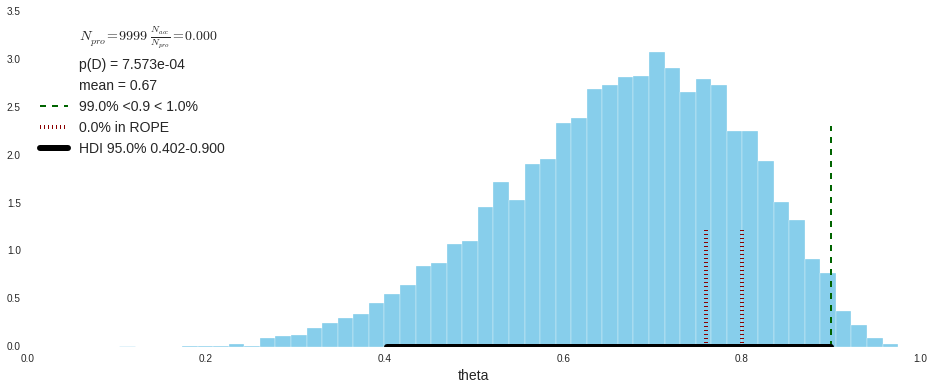

In [35]:

# Specify the length of the trajectory, i.e. the number of jumps to try:
trajLength = 11112 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = N.zeros(trajLength)
# Specify where to start the trajectory:
trajectory[0] = 0.5 # arbitrary value
# Specify the burn-in period:
burnIn = N.ceil(0.1 * trajLength) # arbitrary number, less than trajLength
# Initialize accepted/rejected counters, just to monitor performance
nAccepted = 0
nRejected = 0
# Specify seed to reproduce same random walk
N.random.seed(47405)

# Now generate the random walk. The 't' index is time or trial in the walk

for t in range(trajLength-1):
    currPos=trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    # The shape/variance of the proposal distribution can be changed
    # to whatever you think is appropriate for the target distribution.
    proposedJump=N.random.normal(loc=0,scale=0.1,size=1)
    # Generate a random uniform value from the interval [0,1]
    acceptCrit = N.random.uniform(size=1)
    # Compute the probability of accepting the proposed jump:
    probAccept = N.minimum(1,TargetRelProb(currPos + proposedJump,myData)/TargetRelProb(currPos,myData))
    if acceptCrit < probAccept:
        # accept the proposed jump
        trajectory[t+1] = currPos + proposedJump
        #increment the acceptance counter (just to monitor performance)
        if t>burnIn:
            nAccepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[t+1] = currPos
        # increment the rejection counter
        if t>burnIn:
            nRejected += 1

#Extract the post burn-in part of the trajectory
acceptedTraj = trajectory[burnIn + 1:]

# END OF METROPOLIS ALGORITHM
#----------------------------------------------------------------------

# Display the posterior

# Display rejected/accepted ratio in the plot
mean_traj = N.mean(acceptedTraj)
std_traj = N.std(acceptedTraj)

plt.figure(figsize=(16,6)) # Brian added

plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(acceptedTraj), (nAccepted/len(acceptedTraj))), alpha=0)

# Evidence for model, p(D).

# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is Bernoulli.
a = mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

# For every theta value in the posterior sample, compute 
# dbeta(theta,a,b) / likelihood(theta)*prior(theta)
# This computation assumes that likelihood and prior are proper densities,
# i.e., not just relative probabilities. This computation also assumes that
# the likelihood and prior functions were defined to accept a vector argument,
# not just a single-component scalar argument.
wtd_evid = beta.pdf(acceptedTraj, a, b) / (Likelihood(acceptedTraj, myData) * Prior(acceptedTraj))
p_data = 1 / N.mean(wtd_evid)


# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

# Display the posterior.
ROPE = N.array([0.76, 0.8])
mcmc_info = plot_post(acceptedTraj, xlab='theta', show_mode=False, comp_val=0.9, ROPE=ROPE)

In [ ]:
# HERE IS THE PYMC VERSION OF THE ABOVE

In [6]:
import numpy as np
gain = np.array([0.9977,0.9912,0.9822,0.9864,0.9956,0.9712,0.9598,1.00]) 
gain105 = np.array([0.9992,0.9933,0.9862,0.9916,1.0042,0.9916,0.9933,1.05]) 
gain095 = np.array([0.9948,0.9870,0.9758,0.9785,0.9841,0.9480,0.9247,0.95])

In [4]:
print gain
print gain105
print gain095

[0.9977, 0.9912, 0.9822, 0.9864, 0.9956, 0.9712, 0.9598, 1.0]
[0.9992, 0.9933, 0.9862, 0.9916, 1.0042, 0.9916, 0.9933, 1.05]
[0.9948, 0.987, 0.9758, 0.9785, 0.9841, 0.948, 0.9247, 0.95]


In [5]:
import matplotlib.pyplot as plt

In [7]:
plt.plot(gain)
plt.plot(gain105,'r')
plt.plot(gain095,'g')

In [8]:
plt.show()